# Fetch Circle Elevations
### Purpose
In this notebook I query the USGS to get elevation data for all of the circles.
This notebook addresses some one of the tasks in Github issue #35

### Author: 
Ian Davis
### Date: 
2020-03-31
### Update Date: 
2020-07-09

### Inputs 
1.1-circles_to_many_stations_usa_weather_data_20200424213015.txt - Tab separated file of the Christmas Bird Count and matches to 1 or more NOAA weather stations.
- Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

1.0-rec-initial-data-cleaning.txt - Tab seperated file of cleaned cbc data where each row is a circle count infomation for a given count year. 

1.2.1-ijd-fetch-circle-elevations-OFFLINE.csv - Previously generated elevation data. This file will be used when you want to get the elevation data from an offline source and aoivd 100,000+ queries.

### Output Files
1.2-ijd-fetch-circle-elevations_20200502155633.csv - Only 1 column is added to the dataset, 'circle_elev'. This column is the elevation in meters for a given latitude and longitude of the circle centroid.

## Steps or Proceedures in the notebook 
- Set runtime options
    - Set option to retrieve elevations from offline source, or through the USGS queries
    - Set option to only test the USGS query (NOTE: running the query function for the whole dataset will take 24+ hours)
- Create a function to make a remote request to the USGS API
- Create a function to supply inputs to the remote request and return the elevation value
- Main sequence
    - Read in dataset
    - Create a list of unique lat lon combinations 
    - Loop through the unique lat lons to get elevation data from usgs
    - (Optional) Retrieve elevations from offline data source instead of queries
    - Merge in the unique lat lon data with the full paired data file
    - Write new dataset .txt file

## References
- elevation query: https://stackoverflow.com/questions/58350063/obtain-elevation-from-latitude-longitude-coordinates-with-a-simple-python-script
- lamda functions: https://thispointer.com/python-how-to-use-if-else-elif-in-lambda-functions/
- apply on Nulls: https://stackoverflow.com/questions/26614465/python-pandas-apply-function-if-a-column-value-is-not-null

In [422]:
# Imports 
import pandas as pd
import numpy as np
import requests
import urllib
import urllib3
import time
import gzip
import logging
import sys
from datetime import datetime

In [423]:
# Check to see if you are running 32-bit Python (output would be False)
# 32-bit Python could result in Memory Error when reading in large dataset
import sys
sys.maxsize > 2**32

True

## Set File Paths and Runtime Options

In [424]:
# Used to classify the name 
time_now = datetime.today().strftime('%Y%m%d%H%M%S')

# File paths and script options
PATH_TO_PAIRED_DATA = "../data/Cloud_Data/1.1-circles_to_many_stations_usa_weather_data_20200710111406.txt"
PATH_TO_CLEAN_CBC_DATA = "../data/Cloud_Data/1.0-rec-initial-data-cleaning.txt"
PATH_TO_OFFLINE_ELEVATION_DATA = "../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-OFFLINE.csv"
PATH_TO_OFFLINE_STATION_ELEVATION_DATA = "../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-STATION-DATA-OFFLINE.csv"
PATH_TO_LOG_FILE = "../data/Cloud_Data/1.2-ijd-fetch_circle_elevations_"+time_now+".log"

# option to pull offline elevation data from the /attic instead of running the queries
get_offline_data = True
get_offline_data_station = True

# option to run a simple test of the query; only 1000 rows are queried instead of full dataset
test_query = False



## Load in the Clean Data to Create a List of Unique Locations 

In [425]:
clean_data = pd.read_csv(PATH_TO_CLEAN_CBC_DATA, encoding = "ISO-8859-1", sep="\t")

print(clean_data.shape)

clean_data['ui'].nunique()

clean_data.head()

(90411, 48)


/Users/rcdebaca/.pyenv/versions/funhacks371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,max_snow_imperial,min_temp_imperial,max_temp_imperial,min_temp_metric,max_temp_metric,min_wind_metric,max_wind_metric,min_wind_imperial,max_wind_imperial,ui
0,Pacific Grove,US-CA,36.616700,-121.916700,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.6167-121.9167_1901
1,Pueblo,US-CO,38.175251,-104.519575,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.175251-104.519575_1901
2,Bristol,US-CT,41.671800,-72.949500,1901,1900-12-25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6718-72.9495_1901
3,Norwalk,US-CT,41.116700,-73.400000,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.1167-73.4_1901
4,Glen Ellyn,US-IL,41.883300,-88.066700,1901,1900-12-25,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.8833-88.0667_1901


In [426]:
# Create a Temportary String to Merge on
clean_data['temp_key_str'] = round(clean_data['lat'],3).astype(str) + round(clean_data['lon'],3).astype(str)
    
print("The number of unique Lat Lon combos in the dataset is: ")   
clean_data['temp_key_str'].nunique()

The number of unique Lat Lon combos in the dataset is: 


4584

In [427]:
clean_data_unique = clean_data[["lat", "lon", "temp_key_str"]]
clean_data_unique.shape

(90411, 3)

In [428]:
clean_data_unique = clean_data_unique.drop_duplicates("temp_key_str")
clean_data_unique.shape

(4584, 3)

In [429]:
clean_data_unique.head()

,lat,lon,temp_key_str
0,36.616700,-121.916700,36.617-121.917
1,38.175251,-104.519575,38.175-104.52
2,41.671800,-72.949500,41.672-72.95
3,41.116700,-73.400000,41.117-73.4
4,41.883300,-88.066700,41.883-88.067


In [430]:
# Save the Data if nessasary 
# clean_data_unique.to_csv('../data/Cloud_data/1.2-ijd-fetch-circle-elevations_usgs.csv', index=False)

## Create a Log File

In [431]:
# if not get_offline_data:
#     logging.basicConfig(filename=PATH_TO_LOG_FILE, 
#                         filemode='w', 
#                         format='%(message)s', 
#                         level=logging.INFO)
#     logging.info('This log file shows the row index, lat, lon\n')

## Create a function to make a remote request to the USGS API

In [432]:
def make_remote_request(url: str, params: dict):
    """
    Makes the remote request
    Continues making attempts until it succeeds
    """

    count = 1
    while True:
        try:
            response = requests.get((url + urllib.parse.urlencode(params)))
            time.sleep(1)
        except (OSError, urllib3.exceptions.ProtocolError) as error:
            logging.info('\n')
            logging.info('*' * 20, 'Error Occured', '*' * 20)
            logging.info(f'Number of tries: {count}')
            logging.info(f'URL: {url}')
            logging.info(error)
            logging.info('\n')
            count += 1
            time.sleep(0.5)
            continue
        break

    return response

## Create a function to supply inputs to the remote request and return the elevation value

In [433]:
def elevation_function(x):
    """
    @partan
    x - pd.Series where the first eliment x[0] is lat and the second x[1] is lon 
    returns elevation in meters
    
    @example elevation_function(pd.Series(['42.816697', '-114.900003']))
    """
    
    url = 'https://nationalmap.gov/epqs/pqs.php?'
    params = {'x': x[1], # lon
              'y': x[0], # # Lat 
              'units': 'Meters',
              'output': 'json'}
    logging.info(str(x.name)+'\t\t'+str(x[0])+'\t\t'+str(x[1]))   # print row index, lat, lon
    result = make_remote_request(url, params)
    
    return result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']

In [434]:
# Lat Lon
# 42.816697-114.900003

print(clean_data_unique.loc[clean_data_unique['temp_key_str'].str.contains('42.817-114.9'),:])


# Lat Lon
print(elevation_function(pd.Series(['42.816697', '-114.900003'])))
# Lon Lat 
print(elevation_function(pd.Series(['-114.900003', '42.816697'])))
# elevation_function(clean_data_unique.loc[clean_data_unique['temp_key_str'].str.contains('42.817-114.9')][["lat", "lon"]])
# elevation_function([["lat", "lon"]])

# 39.6667-79.8667_1966
print(clean_data_unique.loc[clean_data_unique['temp_key_str'].str.contains('39.667-79.867')])
# Lat Lon
print(elevation_function(pd.Series(['39.6667', '-79.8667'])))
# Lon Lat 
print(elevation_function(pd.Series(['-79.8667', '39.6667'])))



             lat         lon  temp_key_str
24637  42.816697 -114.900003  42.817-114.9
898.12
-1000000
          lat      lon   temp_key_str
2163  39.6667 -79.8667  39.667-79.867
337.53
-1000000


In [435]:
pd.Series(['42.816697', '-114.900003'])[0]

'42.816697'

# Collect Data From USGS for the unique Lat Lon Locations 

In [436]:
if not get_offline_data:
#     temp = clean_data_unique[['lat', 'lon']]

    clean_data_unique.loc[:, 'circle_elev'] = np.nan
    clean_data_unique.head(50)

    testing_count = 0

    for index, row in clean_data_unique.iterrows():

        try:
            print(row['temp_key_str'])
            # combination of apply() function and lambda() function, only on nulls (see reference links above)
            clean_data_unique.loc[index, 'circle_elev'] = elevation_function(row[['lat', 'lon']])
        except:
            print("Exception occurred:")
            print(row['temp_key_str'])        
            clean_data_unique.loc[index, 'circle_elev'] = np.nan
            continue

        if test_query:
            testing_count = testing_count + 1
            if testing_count >= 5:
                break
                
        time.sleep(2)



In [437]:
# check on the results 
if not get_offline_data:
    print("The number of elivations that got an NAN is: " + str(clean_data_unique['circle_elev'].isna().sum()))
    print(clean_data_unique['circle_elev'].head(10))
    print(clean_data_unique['circle_elev'].dtype)

In [438]:
# Add the result list as circle_elev
if not get_offline_data:
    clean_data_unique["circle_elev"] = clean_data_unique["circle_elev"].astype('float')
    print(clean_data_unique['circle_elev'].dtype)

In [439]:
# Save this as the offline data
# if not get_offline_data:
#     clean_data_unique.to_csv('../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-OFFLINE.csv', index=False)

## Merge in the data with the Paired dataset. Use offline data for Merge is the variable get_offline_data above is True 

In [440]:
# Load in the full dataset 
paired_df = pd.read_csv(PATH_TO_PAIRED_DATA, encoding = "ISO-8859-1", compression='gzip', sep="\t")

print("The shape of the paired datafram is: " + str(paired_df.shape))

# Create a key for the paired data to merge on 
paired_df['temp_key_str'] = paired_df['lat'].astype(str) + paired_df['lon'].astype(str)

paired_df['temp_key_str'] = round(paired_df['lat'],3).astype(str) + round(paired_df['lon'],3).astype(str)

# Count the number of unique
print("The number of unique latlon combos is " + str(paired_df["temp_key_str"].nunique()))


# Merge on either the clean data collected from usgs or offline data
if not get_offline_data:
    # Merge in on the key 
    paired_df_ = pd.merge(paired_df, clean_data_unique[['temp_key_str', 'circle_elev']], how="left", left_on="temp_key_str", right_on="temp_key_str")

else:
    offline_data = pd.read_csv(PATH_TO_OFFLINE_ELEVATION_DATA)
    # Merge in on the key 
    paired_df_ = pd.merge(paired_df, offline_data[['temp_key_str', 'circle_elev']], how="left", left_on="temp_key_str", right_on="temp_key_str")
    
    

/Users/rcdebaca/.pyenv/versions/funhacks371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62,63,64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of the paired datafram is: (756378, 66)
The number of unique latlon combos is 3848


In [441]:
# Check the merge 
print("The shape of the merged data is : " + str(paired_df_.shape))
print("The number of NAs in the merged data: " + str(paired_df_['circle_elev'].isna().sum()))
print("The number of circles with %s:" % 'circle_elev' + str(paired_df_.shape[0] - paired_df_['circle_elev'].isna().sum()))
print("Value Counts")
print(paired_df_['circle_elev'].value_counts( bins = [-10000,0,1000,2000,3000,4000,5000,6000,8000,9000,10000,12000,14000]))


The shape of the merged data is : (756378, 68)
The number of NAs in the merged data: 0
The number of circles with circle_elev:756378
Value Counts
(0.0, 1000.0]         615638
(1000.0, 2000.0]       99548
(2000.0, 3000.0]       19385
(-10000.001, 0.0]      16955
(3000.0, 4000.0]        4113
(12000.0, 14000.0]         0
(10000.0, 12000.0]         0
(9000.0, 10000.0]          0
(8000.0, 9000.0]           0
(6000.0, 8000.0]           0
(5000.0, 6000.0]           0
(4000.0, 5000.0]           0
Name: circle_elev, dtype: int64


In [442]:
paired_df_.head()

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,precipitation_value,temp_avg,snow,snwd,am_rain,pm_rain,am_snow,pm_snow,temp_key_str,circle_elev
0,Amchitka Island,US-AK,51.409713,179.284881,1980,1979-12-18,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,3,2,2,51.41179.285,-1000000.0
1,Amchitka Island,US-AK,51.409713,179.284881,1980,1979-12-18,4.0,NaN,NaN,NaN,...,5.0,NaN,3.0,0.0,3,3,2,2,51.41179.285,-1000000.0
2,Amchitka Island,US-AK,51.409713,179.284881,1993,1992-12-20,2.0,0.0,1.0,1.0,...,NaN,NaN,0.0,0.0,4,4,4,4,51.41179.285,-1000000.0
3,Amchitka Island,US-AK,51.409713,179.284881,1993,1992-12-20,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,4,4,4,4,51.41179.285,-1000000.0
4,Amchitka Island,US-AK,51.409713,179.284881,1994,1993-12-28,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,4,4,4,4,51.41179.285,-1000000.0


## Screen Circle Elevation Data

In [443]:
# Remove bad elevation values Wre the circle eleivation is less than -10000 
paired_df_.loc[paired_df_['circle_elev'] < -10000.0, 'circle_elev'] = np.nan 

In [444]:
paired_df_[['lat', 'lon', 'count_date', 'circle_elev']].head()

,lat,lon,count_date,circle_elev
0,51.409713,179.284881,1979-12-18,NaN
1,51.409713,179.284881,1979-12-18,NaN
2,51.409713,179.284881,1992-12-20,NaN
3,51.409713,179.284881,1992-12-20,NaN
4,51.409713,179.284881,1993-12-28,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121aeceb8>]],
      dtype=object)

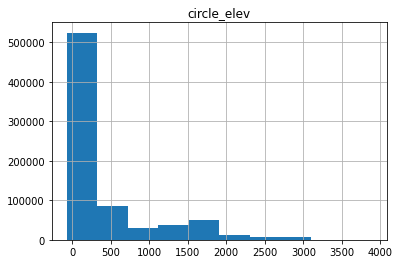

In [445]:
# Create histogram of elevations
paired_df_.hist(column='circle_elev')

# Screen Station Elevation Data

In [446]:
# Check for these bad elivation values for stations 
paired_df_.loc[paired_df_['elevation'] <= -999.9, 'elevation'] 

43       -999.9
45       -999.9
50       -999.9
52       -999.9
58       -999.9
          ...  
755847   -999.9
755877   -999.9
755884   -999.9
755892   -999.9
755914   -999.9
Name: elevation, Length: 6142, dtype: float64

In [447]:
paired_df_.loc[paired_df_['elevation'].isna(),'elevation']

Series([], Name: elevation, dtype: float64)

In [448]:
sum(paired_df['elevation'].isna())

0

In [449]:
# paired_df_.loc[:,['id', 'circle_elev','latitude', 'longitude' ,'elevation']].sort_values(['elevation'], ascending = True)

bad_stat_el_df = paired_df_.loc[(paired_df_['elevation'] <= -999.9) | (paired_df_['elevation'].isna()),['id', 'circle_elev','latitude', 'longitude' ,'elevation']]

# bad_stat_el_df = paired_df_.loc[(paired_df_['elevation'] <= -999.9),['id', 'circle_elev','latitude', 'longitude' ,'elevation']]


bad_stat_el_df.drop_duplicates('id', inplace = True)

print(bad_stat_el_df.shape)
print(bad_stat_el_df.head())

(206, 5)
               id  circle_elev  latitude  longitude  elevation
43    USC00172390       138.62   46.6167   -67.9000     -999.9
1725  USC00202045       320.44   47.4167   -88.1000     -999.9
2533  USC00206744       339.03   46.2833   -87.4667     -999.9
3984  USC00473532       441.96   45.5000   -89.7500     -999.9
6783  USC00174189        45.89   44.3167   -69.7667     -999.9


In [450]:
print(sum(paired_df_['elevation'].isna()))
print(paired_df_.shape)
#756378

0
(756378, 68)


In [451]:
# There appears to be stations with bad data for elivation. Lets see if we can recover any of these from usgs 

if not get_offline_data_station:
#     temp = clean_data_unique[['lat', 'lon']]

    bad_stat_el_df.loc[:, 'elevation_rec'] = np.nan
    bad_stat_el_df.head(50)

    testing_count = 0

    for index, row in bad_stat_el_df.iterrows():

        try:
            print(row['id'])
            # combination of apply() function and lambda() function, only on nulls (see reference links above)
            bad_stat_el_df.loc[index, 'elevation_rec'] = elevation_function(row[['latitude', 'longitude']])
        except:
            print("Exception occurred:")
            print(row['id'])        
            bad_stat_el_df.loc[index, 'elevation_rec'] = np.nan
            continue

        if test_query:
            testing_count = testing_count + 1
            if testing_count >= 5:
                break
                
        time.sleep(2)

In [452]:
# Add in a column to signal that these station elivations came from arc GIS 
bad_stat_el_df['elevation_source'] = "usgs_api"
bad_stat_el_df.head()

,id,circle_elev,latitude,longitude,elevation,elevation_source
43,USC00172390,138.62,46.6167,-67.9000,-999.9,usgs_api
1725,USC00202045,320.44,47.4167,-88.1000,-999.9,usgs_api
2533,USC00206744,339.03,46.2833,-87.4667,-999.9,usgs_api
3984,USC00473532,441.96,45.5000,-89.7500,-999.9,usgs_api
6783,USC00174189,45.89,44.3167,-69.7667,-999.9,usgs_api


In [453]:
#Save this as the offline data
if not get_offline_data_station:
    bad_stat_el_df.to_csv('../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-STATION-DATA-OFFLINE.csv', index=False)


In [454]:
if get_offline_data_station:
    bad_stat_el_df = pd.read_csv('../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations-STATION-DATA-OFFLINE.csv')
    print(bad_stat_el_df.shape)
    print(bad_stat_el_df.head())
    

(206, 7)
            id  circle_elev  latitude  longitude  elevation  elevation_rec  \
0  USC00172390       138.62   46.6167   -67.9000     -999.9         209.98   
1  USC00202045       320.44   47.4167   -88.1000     -999.9         324.55   
2  USC00206744       339.03   46.2833   -87.4667     -999.9         373.84   
3  USC00473532       441.96   45.5000   -89.7500     -999.9         444.47   
4  USC00174189        45.89   44.3167   -69.7667     -999.9          31.30   

  elevation_source  
0         usgs_api  
1         usgs_api  
2         usgs_api  
3         usgs_api  
4         usgs_api  


In [455]:
# Check the Size of the paired_df_
paired_df_.shape

(756378, 68)

In [456]:
# Merge in the data with the paired data 
if not get_offline_data_station:
    # Merge in on the key 
    paired_df_ = pd.merge(paired_df_, bad_stat_el_df[['id', 'elevation_rec', 'elevation_source']], how="left", left_on="id", right_on="id")

else:
    offline_data = pd.read_csv(PATH_TO_OFFLINE_STATION_ELEVATION_DATA)
    # Merge in on the key 
    paired_df_ = pd.merge(paired_df_, offline_data[['id', 'elevation_rec', 'elevation_source']], how="left", left_on="id", right_on="id")
    



In [457]:
# Check the Size of the paired_df_
paired_df_.shape

(756378, 70)

In [458]:
# Now we have recovered elivations for the elivations that are -999.9. 
paired_df_.loc[:, ['elevation','elevation_rec', 'elevation_source']].sort_values(['elevation'], ascending = True)

,elevation,elevation_rec,elevation_source
195671,-999.9,356.85,usgs_api
448859,-999.9,341.09,usgs_api
448867,-999.9,341.09,usgs_api
448871,-999.9,341.09,usgs_api
448878,-999.9,341.09,usgs_api
...,...,...,...
738707,3553.1,NaN,NaN
738833,3553.1,NaN,NaN
738715,3553.1,NaN,NaN
738796,3553.1,NaN,NaN


In [459]:
# Remove bad elevation values Wre the station eleivation is less than -10000 
paired_df_.loc[paired_df_['elevation_rec'] < -10000.0, 'elevation_rec'] = np.nan 

In [460]:
# If we are NOT replacing a value, change elevation_source to ghnc_d
paired_df_['elevation_source'] = np.where((paired_df_['elevation'] != -999.9) | (paired_df_['elevation'].isna()), 'ghcn_d', paired_df_['elevation_source'])


# Replace the elivations with -999.9 with the value of elevation_rec 
paired_df_.loc[paired_df_['elevation'] == -999.9] 
paired_df_['elevation'] = np.where(paired_df_['elevation'] == -999.9, paired_df_['elevation_rec'], paired_df_['elevation'])
paired_df_['elevation'] = paired_df_['elevation'].astype('str')



In [461]:
# Now we have recovered elivations for the elivations that are -999.9. 
paired_df_.loc[:, ['circle_elev','id', 'elevation','elevation_rec', 'elevation_source']].sort_values(['elevation'], ascending = True)



,circle_elev,id,elevation,elevation_rec,elevation_source
388466,0.09,USC00081305,-0.14,-0.14,usgs_api
388540,0.09,USC00081305,-0.14,-0.14,usgs_api
388543,0.09,USC00081305,-0.14,-0.14,usgs_api
388548,0.09,USC00081305,-0.14,-0.14,usgs_api
388550,0.09,USC00081305,-0.14,-0.14,usgs_api
...,...,...,...,...,...
745607,NaN,USC00516271,nan,NaN,usgs_api
745612,NaN,USC00516271,nan,NaN,usgs_api
745614,NaN,USC00516271,nan,NaN,usgs_api
745624,NaN,USC00516271,nan,NaN,usgs_api


In [462]:
# Remove the elevation_rec field since we incorperated the data into the elevation field 
paired_df_ = paired_df_.drop(columns = 'elevation_rec')

# Check the Final Output

In [463]:
# Same number of rows? Should be 109390
len(paired_df_.index)

756378

In [464]:
# sort dataframe on existing index
paired_df_.sort_values(['ui'], ascending=[True], inplace=True)

In [465]:
# Remove the temp key 
# Drop the temportary key 
paired_df_ = paired_df_.drop("temp_key_str",axis=1)

In [466]:
paired_df_.head()

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,precipitation_value,temp_avg,snow,snwd,am_rain,pm_rain,am_snow,pm_snow,circle_elev,elevation_source
748672,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1955,1955-01-01,11.0,NaN,NaN,NaN,...,180.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1228.18,ghcn_d
748673,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1956,1955-12-31,11.0,NaN,NaN,NaN,...,290.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1228.18,ghcn_d
748674,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,2,3,3,1228.18,ghcn_d
748675,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,2,3,3,1228.18,ghcn_d
748676,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,2,3,3,1228.18,usgs_api


In [467]:
print('Missing elevations:')
paired_df_['circle_elev'].isna().value_counts()

Missing elevations:


False    755639
True        739
Name: circle_elev, dtype: int64

In [468]:
print('How many elevations at sea level?')
paired_df_.loc[paired_df_['circle_elev'] == 0.0].shape

How many elevations at sea level?


(8531, 68)

## Save the output

In [469]:
#But First Some QA checks (Should be checked against the input file and previous notebooks)
paired_df_.shape

(756378, 68)

In [470]:
paired_df_['ui'].nunique()

80765

In [471]:
paired_df_.to_csv("../data/Cloud_Data/1.2.1-ijd-fetch-circle-elevations_"+time_now+".txt", 
                     sep='\t', 
                     compression='gzip',
                     index=False)